In [311]:
import sys
sys.path.insert(1, '..')

import pecnet as pc
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from models import Model, FinalModel

In [312]:
import tensorflow as tf
import os 
import random
#This is for getting the same results. 
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
reset_random_seeds(42)

In [313]:
def read(station, start, end):
    if isinstance(start, datetime):
        start = np.datetime64(start)
    if isinstance(end, datetime):
        end = np.datetime64(end)

    path = f'{station}_1min.dat'
    with open(path, "rb") as file:
        file.seek(int((start-np.datetime64('2000-01-01'))/np.timedelta64(1, 'm'))*4)
        minutes = int((end-start)/np.timedelta64(1, 'm'))
        data = np.frombuffer(file.read(minutes*4), np.float32)
    times = np.arange(start, end, np.timedelta64(1, 'm'))
    return times, data

In [314]:
start = np.datetime64('2002-01-01') # enter time range
end = np.datetime64('2012-12-31') # 2000 to 2040 time range
DATA_FOLDER = "../data/"
STATION_NAME = "54_SAK_UNIV_PROB"

timesSignal, dataSignal = read(DATA_FOLDER + STATION_NAME, start, end)
mags = pd.read_csv(DATA_FOLDER+"magnitudes.csv", index_col=0).fillna(0).reset_index()
mags["date"] = pd.to_datetime(mags["index"])
efd_df = pd.DataFrame({"value":dataSignal}, index=timesSignal)
#drop_idx = np.argwhere(efd_df.index == pd.to_datetime("2012-12-31 00:00:00")).flatten()[0]#Drop last day
#efd_df = efd_df.iloc[:drop_idx].copy()
mags["72hours"] = np.flip(pc.rolling_op(np.flip(mags["xM"].to_numpy()), 7,np.nanmean))
mags = mags.drop(0).reset_index(drop=True)

In [315]:
df = mags.copy()
df["prev7days"] = pc.rolling_op(mags["72hours"].values, 7, np.nanmax, fill=True, step=1)
df["y_aftersplit"] = np.append(df["prev7days"].values[1:], [0])
df.head(20)

,index,xM,date,72hours,prev7days,y_aftersplit
0,2002-01-02,0.0,2002-01-02,1.700000,1.700000,2.085714
1,2002-01-03,0.0,2002-01-03,2.085714,2.085714,2.542857
2,2002-01-04,3.4,2002-01-04,2.542857,2.542857,2.542857
3,2002-01-05,3.1,2002-01-05,2.400000,2.542857,2.542857
4,2002-01-06,0.0,2002-01-06,2.357143,2.542857,2.728571
5,2002-01-07,2.6,2002-01-07,2.728571,2.728571,2.728571
6,2002-01-08,2.8,2002-01-08,2.357143,2.728571,2.728571
7,2002-01-09,2.7,2002-01-09,2.385714,2.728571,2.728571
8,2002-01-10,3.2,2002-01-10,2.000000,2.728571,2.728571
9,2002-01-11,2.4,2002-01-11,1.885714,2.728571,2.728571


In [316]:
pd.set_option('max_colwidth', 160)
df2 = df.copy()
df2["prev7days"] =  pc.rolling_op(mags["xM"].values, 7, np.nanmean, fill=True, step=1, include_first=False)
DAILY_WINDOW = 8
ENERGY_SPLIT_INDEX= int(mags.shape[0] / 100 * 80)
seventh_data = mags.xM.to_numpy().flatten()
X_7, y_7 = pc.get_xy(seventh_data, DAILY_WINDOW, step =1, fill=True, include_first=False)
df2 = df2.drop(columns=["y_aftersplit"])
#df2["y_aftersplit"] = np.append(y_train_7, y_test_7)
df2["X_7"] = [str(x) for x in X_7]
df2["y_7"] = y_7
df2.head(50)

,index,xM,date,72hours,prev7days,X_7,y_7
0,2002-01-02,0.0,2002-01-02,1.700000,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],0.0
1,2002-01-03,0.0,2002-01-03,2.085714,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],3.4
2,2002-01-04,3.4,2002-01-04,2.542857,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],3.1
3,2002-01-05,3.1,2002-01-05,2.400000,0.485714,[0. 0. 0. 0. 0. 0. 0. 3.4],0.0
4,2002-01-06,0.0,2002-01-06,2.357143,0.928571,[0. 0. 0. 0. 0. 0. 3.4 3.1],2.6
5,2002-01-07,2.6,2002-01-07,2.728571,0.928571,[0. 0. 0. 0. 0. 3.4 3.1 0. ],2.8
6,2002-01-08,2.8,2002-01-08,2.357143,1.300000,[0. 0. 0. 0. 3.4 3.1 0. 2.6],2.7
7,2002-01-09,2.7,2002-01-09,2.385714,1.700000,[0. 0. 0. 3.4 3.1 0. 2.6 2.8],3.2
8,2002-01-10,3.2,2002-01-10,2.000000,2.085714,[0. 0. 3.4 3.1 0. 2.6 2.8 2.7],2.4
9,2002-01-11,2.4,2002-01-11,1.885714,2.542857,[0. 3.4 3.1 0. 2.6 2.8 2.7 3.2],2.8


In [317]:
means = []
stds = []

group = efd_df.groupby(pd.Grouper(freq='22.5min', label='right', closed='right'))
mean_efd = group.mean()
stds_efd = group.std()
means.append(mean_efd.reset_index().iloc[:-1])
stds.append(stds_efd.reset_index().iloc[:-1])

freqs = ["3h","1d"]
for freq in freqs:
    group_mean = mean_efd.groupby(pd.Grouper(freq=freq, label='right', closed='right'))
    group_std = stds_efd.groupby(pd.Grouper(freq=freq, label='right', closed='right'))

    means.append(group_mean.max().reset_index().iloc[:-1])
    stds.append(group_std.max().reset_index().iloc[:-1])

freqs = ["22.5min", "3h","1d"]

In [318]:
split_idx = int(mags.shape[0] / 100 * 80)
print(split_idx)

3213


In [319]:
for i, mean_df in enumerate(means):
    print(freqs[i], mean_df.loc[mean_df["index"].dt.date == mags.date[split_idx]].iloc[0])

C:\Users\srknm\AppData\Local\Temp\ipykernel_1412\3383533117.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  print(freqs[i], mean_df.loc[mean_df["index"].dt.date == mags.date[split_idx]].iloc[0])


22.5min index    2010-10-20 00:00:00
value           10610.703125
Name: 205696, dtype: object
3h index    2010-10-20 00:00:00
value           10611.897461
Name: 25712, dtype: object
1d index    2010-10-20 00:00:00
value              10617.375
Name: 3214, dtype: object


In [320]:
# FIRST_SPLIT_INDEX = 205696
# SECOND_SPLIT_INDEX = 25712
# THIRD_SPLIT_INDEX = 3214

ENERGY_SPLIT_INDEX = split_idx
HOURLY_WINDOW = 8 # Last 3 hours
DAILY_WINDOW = 8 # Last 1 day
WEEKLY_WINDOW = 8 # Last 8 days

FIRST_STEP = int(24*60 / 22.5) # 64
SECOND_STEP = int(24*60 / (22.5 * 8))
THIRD_STEP = 1 # 64

HOURLY_START = FIRST_STEP  - HOURLY_WINDOW
DAILY_START  = SECOND_STEP - DAILY_WINDOW 
WEEKLY_START = THIRD_STEP  - WEEKLY_WINDOW # Its minus -7, So you can either fill the data, or cut the first 7 days(need to convert to their freq) from the other ones

op = np.nanmean
first_data =  means[2].value.to_numpy().flatten()
second_data = stds[2].value.to_numpy().flatten()

third_data = means[1].value.to_numpy().flatten()
fourth_data = stds[1].value.to_numpy().flatten()

fifth_data = means[0].value.to_numpy().flatten()
sixth_data = stds[0].value.to_numpy().flatten()

output_data = mags["72hours"].to_numpy().flatten()

# we don't use y_train s and y_test s 
X_train, X_test, y_train, y_test, mean = pc.prepare_and_split_data(first_data, WEEKLY_WINDOW,mean_window_size=WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)
X_train_2, X_test_2, y_train_2, y_test_2, mean_2 = pc.prepare_and_split_data(second_data, WEEKLY_WINDOW,mean_window_size=WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)

X_train_3, X_test_3, y_train_3, y_test_3, mean_3 = pc.prepare_and_split_data(third_data[DAILY_START:], DAILY_WINDOW,mean_window_size=DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_4, X_test_4, y_train_4, y_test_4, mean_4 = pc.prepare_and_split_data(fourth_data[DAILY_START:], DAILY_WINDOW,mean_window_size=DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)

X_train_5, X_test_5, y_train_5, y_test_5, mean_5 = pc.prepare_and_split_data(fifth_data[HOURLY_START:], HOURLY_WINDOW,mean_window_size=HOURLY_WINDOW,  step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_6, X_test_6, y_train_6, y_test_6, mean_6 = pc.prepare_and_split_data(sixth_data[HOURLY_START:], HOURLY_WINDOW,mean_window_size=HOURLY_WINDOW,  step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)

# this is only for output_data when using it only as y_train
y_train_7, y_test_7 = pc.label_train_test(y=output_data, split_index=ENERGY_SPLIT_INDEX)

# this is only for output_data when using it only as X_train (we cannot use y_train_7 and y_test_7 since prepare_and_split_data() does normalization + wavelet)
seventh_data = mags.xM.to_numpy().flatten()
X_train_7, X_test_7, _, _, mean_7 = pc.prepare_and_split_data(seventh_data, DAILY_WINDOW, mean_window_size=DAILY_WINDOW, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)

c:\Users\srknm\.conda\envs\serkanTez\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [321]:
print(X_train.shape, X_train_2.shape, X_train_3.shape, X_train_4.shape, X_train_5.shape, X_train_6.shape, X_train_7.shape)
print(X_test.shape, X_test_2.shape, X_test_3.shape, X_test_4.shape, X_test_5.shape, X_test_6.shape, X_test_7.shape)

(3213, 17) (3213, 17) (3213, 17) (3213, 17) (3213, 17) (3213, 17) (3213, 17)
(804, 17) (804, 17) (804, 17) (804, 17) (804, 17) (804, 17) (804, 17)


In [322]:
#Remove NaN
nan_mask_train = np.isnan(X_train).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_2).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_3).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_4).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_5).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_6).any(axis=1)

nan_mask_test = np.isnan(X_test).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_2).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_3).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_4).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_5).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_6).any(axis=1)


In [323]:
#We will only use X_train and X_tests for efd
#y values for energy
X_train   = X_train[~nan_mask_train]
X_train_2 = X_train_2[~nan_mask_train]
X_train_3 = X_train_3[~nan_mask_train]
X_train_4 = X_train_4[~nan_mask_train]
X_train_5 = X_train_5[~nan_mask_train]
X_train_6 = X_train_6[~nan_mask_train]

X_test   = X_test[~nan_mask_test]
X_test_2 = X_test_2[~nan_mask_test]
X_test_3 = X_test_3[~nan_mask_test]
X_test_4 = X_test_4[~nan_mask_test]
X_test_5 = X_test_5[~nan_mask_test]
X_test_6 = X_test_6[~nan_mask_test]

# select ER as label
y_train = y_train_7[~nan_mask_train]
y_test  = y_test_7[~nan_mask_test]

# drop na's from means
mean_7 = mean_7[~np.append(nan_mask_train, nan_mask_test)]
mean = mean[~np.append(nan_mask_train, nan_mask_test)]

# normalize label
y_train = y_train - mean_7[:len(y_train)]
y_test = y_test - mean_7[len(y_train):]


In [324]:
print(X_train.shape, X_train_2.shape, X_train_3.shape, X_train_4.shape, X_train_5.shape, X_train_6.shape, X_train_7.shape)
print(X_test.shape, X_test_2.shape, X_test_3.shape, X_test_4.shape, X_test_5.shape, X_test_6.shape, X_test_7.shape)

(2764, 17) (2764, 17) (2764, 17) (2764, 17) (2764, 17) (2764, 17) (3213, 17)
(788, 17) (788, 17) (788, 17) (788, 17) (788, 17) (788, 17) (804, 17)


In [325]:
#For creating the between networks
def create_network(X_train, y_train, X_test, y_test, mean, Model, model_name, y_train_real=None, compensated_train=None, compensated_test=None, first=False):
    model = Model(X_train.shape, y_train.shape)
    model.set_model_info(model_name)
    model.set_fit_args()
    model.init_model()

    #model.model.summary()
    hist = model.fit_model(X_train, y_train, verbose=False)

    #Predict for model
    predict_train = model.predict(X_train).flatten()
    predict_test = model.predict(X_test).flatten()
    if first:
        #compensated_train = predict_train + mean[:X_train.shape[0]]
        #compensated_test = predict_test +mean[X_train.shape[0]:]
        
        # don't include mean to calculation
        compensated_train = predict_train
        compensated_test = predict_test
        error_train = predict_train - y_train
        error_test = predict_test - y_test
        return hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test
    #Calculate compensated errors
    compensated_train = compensated_train - predict_train
    compensated_test = compensated_test - predict_test
    #Calculate error for model.
    error_train = compensated_train - y_train_real
    error_test = compensated_test - y_test

    return hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test

## PECNET INPUT:EFD, OUTPUT:ENERGY

In [326]:
out_first = create_network(X_train, y_train, X_test, y_test, mean, Model, "First Model", first=True)
(hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test) = out_first

25/25 [==============================] - 0s 2ms/step


In [327]:
out_second = create_network(X_train_2, error_train, X_test_2, y_test, mean, Model, "Second Model", y_train_real = y_train, compensated_train=compensated_train, compensated_test=compensated_test, first=False)
(hist_2, predict_train_2, predict_test_2, error_train_2, error_test_2, compensated_train_2, compensated_test_2) = out_second

25/25 [==============================] - 0s 1ms/step


In [328]:
out_third = create_network(X_train_3, error_train_2, X_test_3, y_test, mean, Model, "Third Model", y_train_real = y_train, compensated_train=compensated_train_2, compensated_test=compensated_test_2, first=False)
(hist_3, predict_train_3, predict_test_3, error_train_3, error_test_3, compensated_train_3, compensated_test_3) = out_third

25/25 [==============================] - 0s 3ms/step


In [329]:
out_fourth = create_network(X_train_4, error_train_3, X_test_4, y_test, mean, Model, "Fourth Model", y_train_real = y_train, compensated_train=compensated_train_3, compensated_test=compensated_test_3, first=False)
(hist_4, predict_train_4, predict_test_4, error_train_4, error_test_4, compensated_train_4, compensated_test_4) = out_fourth

25/25 [==============================] - 0s 2ms/step


In [330]:
out_fifth = create_network(X_train_5, error_train_4, X_test_5, y_test, mean, Model, "Fifth Model", y_train_real = y_train, compensated_train=compensated_train_4, compensated_test=compensated_test_4, first=False)
(hist_5, predict_train_5, predict_test_5, error_train_5, error_test_5, compensated_train_5, compensated_test_5) = out_fifth

25/25 [==============================] - 0s 3ms/step


In [331]:
out_sixth = create_network(X_train_6, error_train_5, X_test_6, y_test, mean, Model, "Sixth Model", y_train_real = y_train, compensated_train=compensated_train_5, compensated_test=compensated_test_5, first=False)
(hist_6, predict_train_6, predict_test_6, error_train_6, error_test_6, compensated_train_6, compensated_test_6) = out_sixth

25/25 [==============================] - 0s 4ms/step


In [332]:
#Error Network

ERROR_ALIGNMENT = 0
ERROR_WINDOW_SIZE =64
X_train_error, y_train_error, mean_train_error = pc.prepare_data(np.append([0], error_train_6), ERROR_WINDOW_SIZE,mean_window_size=ERROR_WINDOW_SIZE, normalize=True, fill=True,is_error_data=True)
X_test_error, y_test_error, mean_test_error = pc.prepare_data(np.append([0], error_test_6), ERROR_WINDOW_SIZE,mean_window_size=ERROR_WINDOW_SIZE, normalize=True, fill=True,is_error_data=True)

#Error network
error_model = Model(X_train_error.shape, y_train_error.shape)
error_model.set_model_info("Error Model")
error_model.set_fit_args()
error_model.init_model()
# error_model.model.summary()
hist_error = error_model.fit_model(X_train_error, y_train_error, verbose=False)

#Predict for error Model
predict_train_error = error_model.model.predict(X_train_error).flatten()
predict_test_error = error_model.model.predict(X_test_error).flatten()

#Calculate compensated errors.
compensated_train_error = compensated_train_6[ERROR_ALIGNMENT:] - (predict_train_error + mean_train_error)
compensated_test_error = compensated_test_6 - (predict_test_error + mean_test_error)

#Calculate error for error model.
error_train_error = (predict_train_error  + mean_train_error)
error_test_error = (predict_test_error + mean_test_error)

25/25 [==============================] - 0s 3ms/step


In [333]:
#Create Final Network IO
#ERROT_ALIGNMENT: if not zero
X_train_final = np.column_stack((predict_train, predict_train_2, predict_train_3, predict_train_4, predict_train_5, predict_train_6, error_train_error)) 
X_test_final = np.column_stack((predict_test, predict_test_2, predict_test_3, predict_test_4, predict_test_5, predict_test_6, error_test_error))

y_train_final = y_train[ERROR_ALIGNMENT:]
y_test_final = y_test

In [334]:
#Final model
final_model = FinalModel(X_train_final.shape, y_train_final.shape)
final_model.set_model_info("Final Model")
final_model.set_fit_args()
final_model.init_model()
# final_model.model.summary()
hist_final = final_model.fit_model(X_train_final, y_train_final, verbose=False)

#Predict the values
predict_train_final = final_model.predict(X_train_final).flatten()
predict_test_final = final_model.predict(X_test_final).flatten()
#Add mean
predict_train_final = predict_train_final + mean_7[:y_train.shape[0]]
predict_test_final = predict_test_final + mean_7[y_train.shape[0]:]
y_train_plot = y_train + mean_7[:y_train.shape[0]]
y_test_plot = y_test + mean_7[y_train.shape[0]:]

# predict_train_final = predict_train_final
# predict_test_final = predict_test_final
# y_train_plot = y_train
# y_test_plot = y_test


predict_test_final=predict_test_final.clip(min=0)
predict_train_final=predict_train_final.clip(min=0)

25/25 [==============================] - 0s 2ms/step


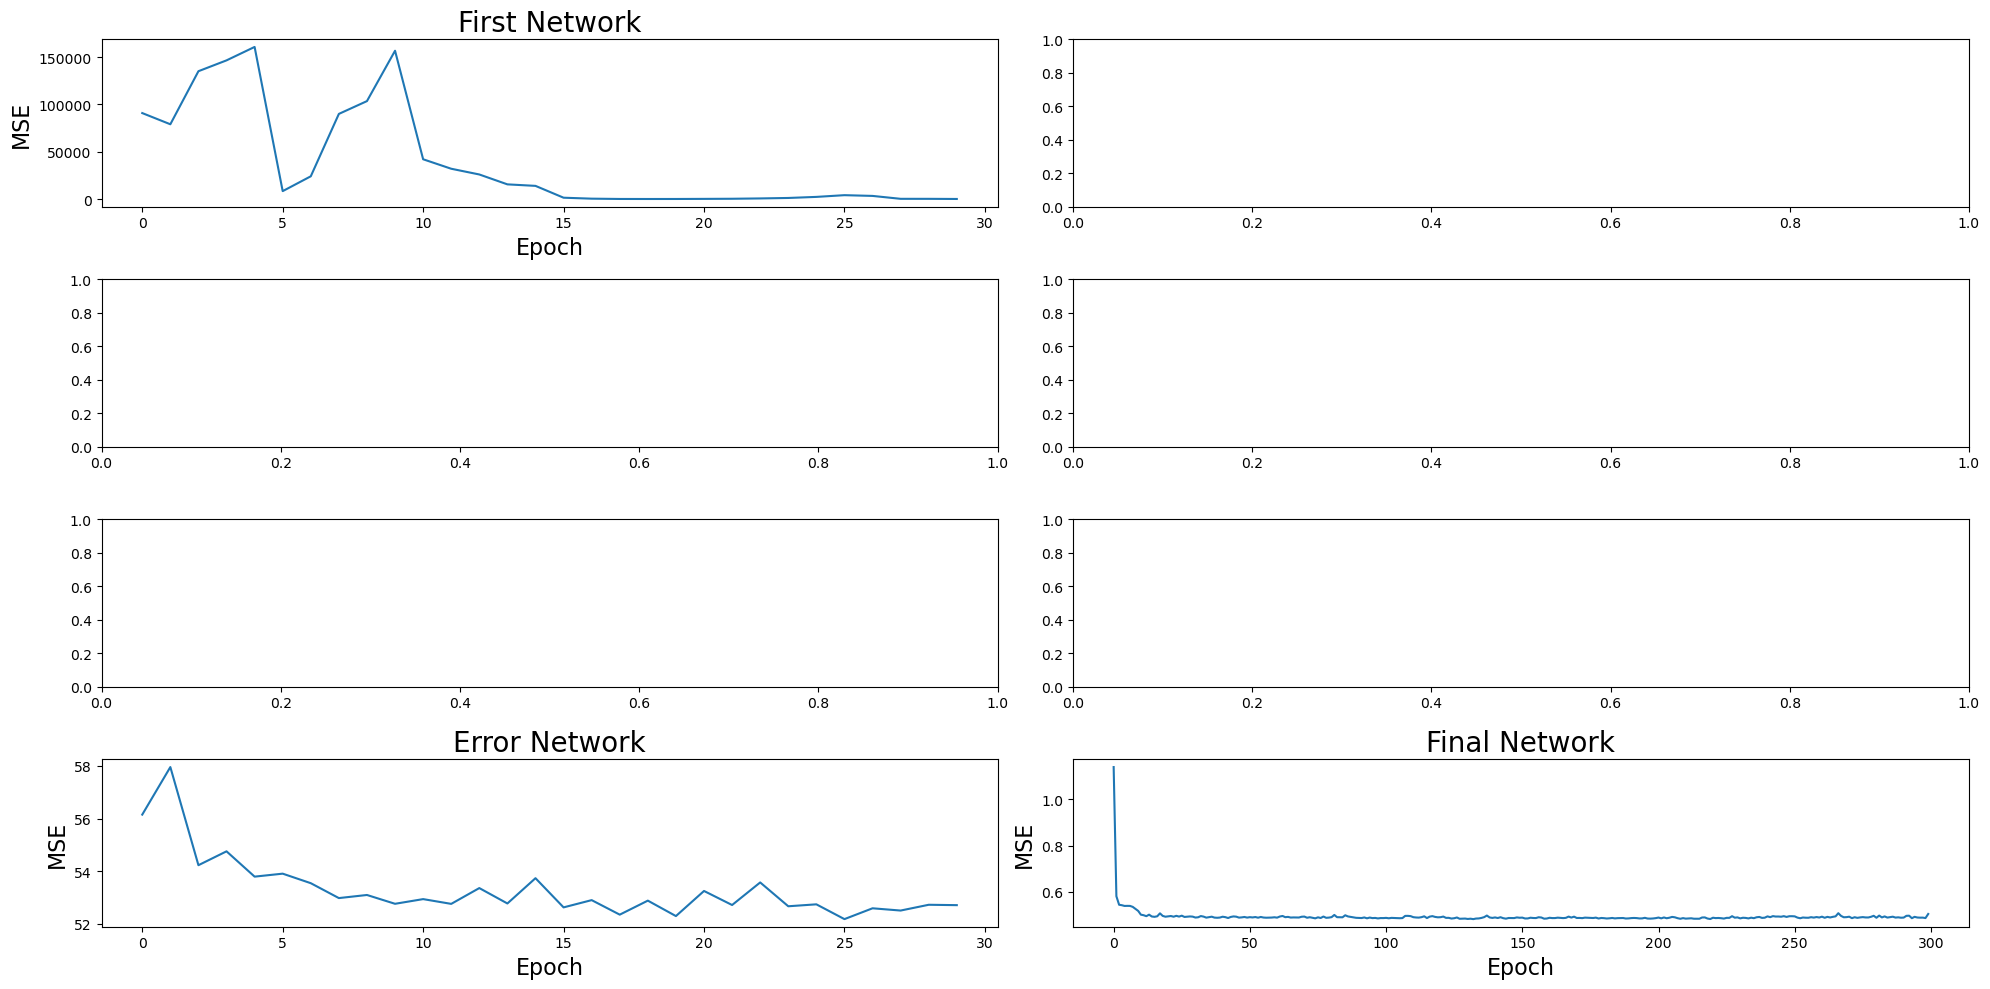

In [335]:
fig, ((ax0,ax1),(ax2,ax3), (ax4,ax5), (ax6,ax7)) = plt.subplots(4,2, figsize=(20,10))

metric = "loss"
x_title = "MSE"
ax0.plot(hist.history[metric])
ax0.set_title("First Network", fontsize=20)
ax0.set_xlabel("Epoch", fontsize=16)
ax0.set_ylabel(x_title, fontsize=16)

ax6.plot(hist_error.history[metric])
ax6.set_title("Error Network", fontsize=20)
ax6.set_xlabel("Epoch", fontsize=16)
ax6.set_ylabel(x_title, fontsize=16)

ax7.plot(hist_final.history[metric])
ax7.set_title("Final Network", fontsize=20)
ax7.set_xlabel("Epoch", fontsize=16)
ax7.set_ylabel(x_title, fontsize=16)


plt.tight_layout()
plt.show()

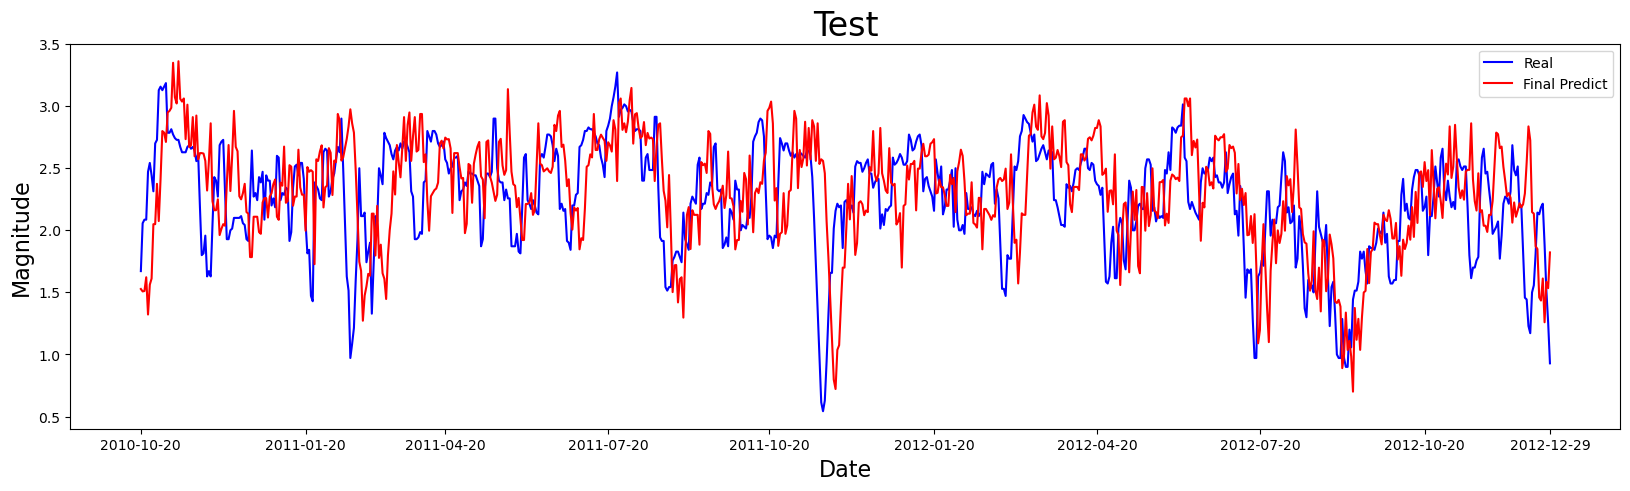

In [336]:
lst=mags["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype("string")
x_axis_date_string=["2010-10-01","2011-01-01","2011-04-01","2011-07-01","2011-10-01","2012-01-01","2012-04-01","2012-07-01","2012-10-01","2013-01-01"]
index_list=[]

plt.figure(figsize=(20,5), dpi=100)
plt.title("Test", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

ticks = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
labels = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
ax = plt.gca()

plt.plot(mags["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), y_test_plot, c='b', label="Real")
plt.plot(mags["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), predict_test_final, c='r', label="Final Predict")
plt.legend()

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
plt.show()

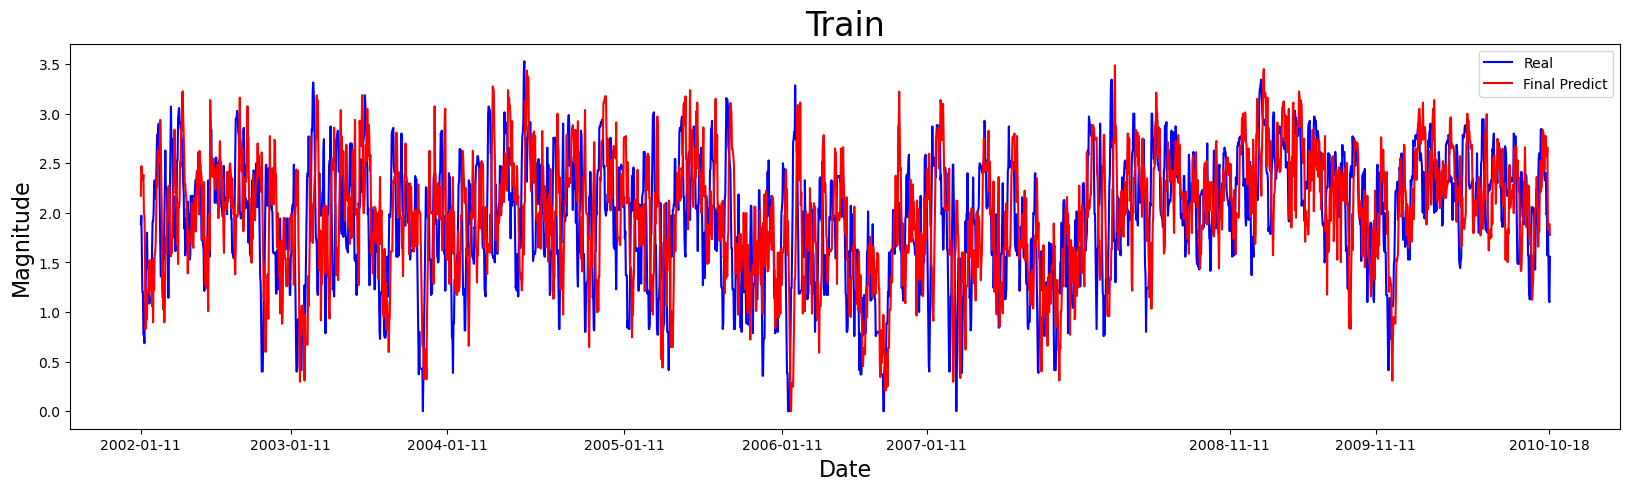

In [337]:
plt.figure(figsize=(20,5), dpi=100)
plt.title("Train", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

ticks = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11", "2008-11-11", "2009-11-11","2010-10-18"]
labels = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11","2008-11-11","2009-11-11", "2010-10-18"]
ax = plt.gca()

plt.plot(mags["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), y_train_plot, c='b', label="Real")
plt.plot(mags["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), predict_train_final, c='r', label="Final Predict")
plt.legend()

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
plt.show()

In [338]:
print("R2\t", "Train: ", r2_score(y_train_plot[1:], y_train_plot[:-1]), "\tTest: ", r2_score(y_test_plot[1:], y_test_plot[:-1]))

R2	 Train:  0.801311005163105 	Test:  0.7906044829079677


In [339]:
#shifting
for i in range(1,10):
    print("R2", "i=", i, "\t", "Train: ", r2_score(y_train_plot[:-i], predict_train_final[i:]), "\tTest: ", r2_score(y_test_plot[:-i], predict_test_final[i:]))

R2 i= 1 	 Train:  -0.11258342869951288 	Test:  -0.07322579512846761
R2 i= 2 	 Train:  0.07616770905357673 	Test:  0.10436510852382219
R2 i= 3 	 Train:  0.2597994503038833 	Test:  0.2614465127672789
R2 i= 4 	 Train:  0.4116304300710527 	Test:  0.3790244721395285
R2 i= 5 	 Train:  0.5359406083234541 	Test:  0.45934327287022547
R2 i= 6 	 Train:  0.6411125009044529 	Test:  0.5767075137499733
R2 i= 7 	 Train:  0.7099324087735086 	Test:  0.6920737062858043
R2 i= 8 	 Train:  0.6234523642394108 	Test:  0.6094304402081703
R2 i= 9 	 Train:  0.4149768245618578 	Test:  0.3813454534635201


In [340]:
print("R2\t", "Train: ", r2_score(y_train_plot, predict_train_final), "\tTest: ", r2_score(y_test_plot[:-1], predict_test_final[:-1]))
print("RMSE\t", "Train: ", mean_squared_error(y_train_plot, predict_train_final, squared=False), "\tTest: ", mean_squared_error(y_test_plot[:-1], predict_test_final[:-1],  squared=False))
print("MAPE\t", "Train: ", mean_absolute_percentage_error(y_train_plot, predict_train_final), "\tTest: ", mean_absolute_percentage_error(y_test_plot[:-1], predict_test_final[:-1]))

R2	 Train:  -0.32835177049193964 	Test:  -0.3098215686046939
RMSE	 Train:  0.6978313156978323 	Test:  0.49013098754603823
MAPE	 Train:  16186069206353.346 	Test:  0.19543990444864034


In [341]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
import pywt

# Exponential Smoothing (EWMA alpha=0.6)
def exponential_smoothing(signal, alpha):
    smoothed_signal = np.zeros_like(signal)
    smoothed_signal[0] = signal[0]
    for i in range(1, len(signal)):
        smoothed_signal[i] = alpha * signal[i] + (1 - alpha) * smoothed_signal[i-1]
    return smoothed_signal

alpha = 0.6
predict_test_final_smoothed_exp = exponential_smoothing(predict_test_final, alpha)
predict_train_final_smoothed_exp = exponential_smoothing(predict_train_final, alpha)

# Savitzky-Golay Filtering (window=11, order=3)
window_length = 11
poly_order = 3
predict_test_final_smoothed_sg = savgol_filter(predict_test_final, window_length, poly_order)
predict_train_final_smoothed_sg = savgol_filter(predict_train_final, window_length, poly_order)

# Gaussian Smoothing
sigma = 2
predict_test_final_smoothed_gauss = gaussian_filter1d(predict_test_final, sigma)
predict_train_final_smoothed_gauss = gaussian_filter1d(predict_train_final, sigma)

# Median Filtering
window_size = 7  # Window size for median filtering
predict_test_final_smoothed_med = medfilt(predict_test_final, kernel_size=window_size)
predict_train_final_smoothed_med = medfilt(predict_train_final, kernel_size=window_size)

# Wavelet Denoising db4 (th=0.5)
mean_predict_test_final = np.mean(predict_test_final)
std_predict_test_final = np.std(predict_test_final)
wavelet = 'db4'  # Wavelet type
threshold = 0.5  # Threshold for wavelet coefficients
normalized_test_final = (predict_test_final - mean_predict_test_final) / std_predict_test_final # normalization
wavelet_coeffs_test = pywt.wavedec(normalized_test_final, wavelet)
thresholded_coeffs_test = [pywt.threshold(c, threshold, 'soft') for c in wavelet_coeffs_test]
predict_test_final_denoised_signal = pywt.waverec(thresholded_coeffs_test, wavelet)
predict_test_final_denoised_db4 = predict_test_final_denoised_signal * std_predict_test_final + mean_predict_test_final # denormalization

mean_predict_train_final = np.mean(predict_train_final)
std_predict_train_final = np.std(predict_train_final)
normalized_train_final = (predict_train_final - mean_predict_train_final) / std_predict_train_final # normalization
wavelet_coeffs_train = pywt.wavedec(normalized_train_final, wavelet)
thresholded_coeffs_train = [pywt.threshold(c, threshold, 'soft') for c in wavelet_coeffs_train]
predict_train_final_denoised_signal = pywt.waverec(thresholded_coeffs_train, wavelet)
predict_train_final_denoised_db4 = predict_train_final_denoised_signal * std_predict_train_final + mean_predict_train_final # denormalization

# Wavelet Denoising sym4
wavelet = 'sym2'  # Wavelet type
threshold = 0.5  # Threshold for wavelet coefficients
wavelet_coeffs_test = pywt.wavedec(normalized_test_final, wavelet)
thresholded_coeffs_test = [pywt.threshold(c, threshold, 'soft') for c in wavelet_coeffs_test]
predict_test_final_denoised_signal = pywt.waverec(thresholded_coeffs_test, wavelet)
predict_test_final_denoised_sym2 = predict_test_final_denoised_signal * std_predict_test_final + mean_predict_test_final # denormalization

wavelet_coeffs_train = pywt.wavedec(normalized_train_final, wavelet)
thresholded_coeffs_train = [pywt.threshold(c, threshold, 'soft') for c in wavelet_coeffs_train]
predict_train_final_denoised_signal = pywt.waverec(thresholded_coeffs_train, wavelet)
predict_train_final_denoised_sym2 = predict_train_final_denoised_signal * std_predict_train_final + mean_predict_train_final # denormalization

# Wavelet Denoising haar
wavelet = 'haar'  # Wavelet type
threshold = 0.5  # Threshold for wavelet coefficients
wavelet_coeffs_test = pywt.wavedec(normalized_test_final, wavelet)
thresholded_coeffs_test = [pywt.threshold(c, threshold, 'soft') for c in wavelet_coeffs_test]
predict_test_final_denoised_signal = pywt.waverec(thresholded_coeffs_test, wavelet)
predict_test_final_denoised_haar = predict_test_final_denoised_signal * std_predict_test_final + mean_predict_test_final # denormalization

wavelet_coeffs_train = pywt.wavedec(normalized_train_final, wavelet)
thresholded_coeffs_train = [pywt.threshold(c, threshold, 'soft') for c in wavelet_coeffs_train]
predict_train_final_denoised_signal = pywt.waverec(thresholded_coeffs_train, wavelet)
predict_train_final_denoised_haar = predict_train_final_denoised_signal * std_predict_train_final + mean_predict_train_final # denormalization

In [342]:
def print_plots_and_results(predict_train_smoothed, predict_test_smoothed, label_name_smoothed):
    # RESULTS FOR SMOOTHING METHOD
    plt.figure(figsize=(20,10), dpi=100)
    plt.subplot(2, 1, 1)
    plt.title("Train", fontsize=24)
    plt.xlabel("Date", fontsize=16)
    plt.ylabel("Magnitude", fontsize=16)
    ticks = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11", "2008-11-11", "2009-11-11","2010-10-18"]
    labels = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11","2008-11-11","2009-11-11", "2010-10-18"]
    ax = plt.gca()
    plt.plot(mags["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), y_train_plot, c='b', label="Real")
    plt.plot(mags["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), predict_train_final, c='g', label="Final Predict")
    plt.plot(mags["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), predict_train_smoothed, c='r', label=label_name_smoothed)
    plt.legend()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=0)
    plt.show()

    plt.figure(figsize=(20,10), dpi=100)
    plt.subplot(2, 1, 2)
    plt.title("Test", fontsize=24)
    plt.xlabel("Date", fontsize=16)
    plt.ylabel("Magnitude", fontsize=16)
    ticks = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
    labels = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
    ax = plt.gca()
    plt.plot(mags["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), y_test_plot, c='b', label="Real")
    plt.plot(mags["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), predict_test_final, c='g', label="Final Predict")
    plt.plot(mags["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), predict_test_smoothed, c='r', label=label_name_smoothed)
    plt.legend()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=0)
    plt.show()

    print("R2\t", "Train: ", r2_score(y_train_plot, predict_train_smoothed), "\tTest: ", r2_score(y_test_plot[:-1], predict_test_smoothed[:-1]))
    print("RMSE\t", "Train: ", mean_squared_error(y_train_plot, predict_train_smoothed, squared=False), "\tTest: ", mean_squared_error(y_test_plot[:-1], predict_test_smoothed[:-1],  squared=False))
    # print("MAPE\t", "Train: ", mean_absolute_percentage_error(y_train_plot, predict_train_smoothed), "\tTest: ", mean_absolute_percentage_error(y_test_plot[:-1], predict_test_smoothed[:-1]))

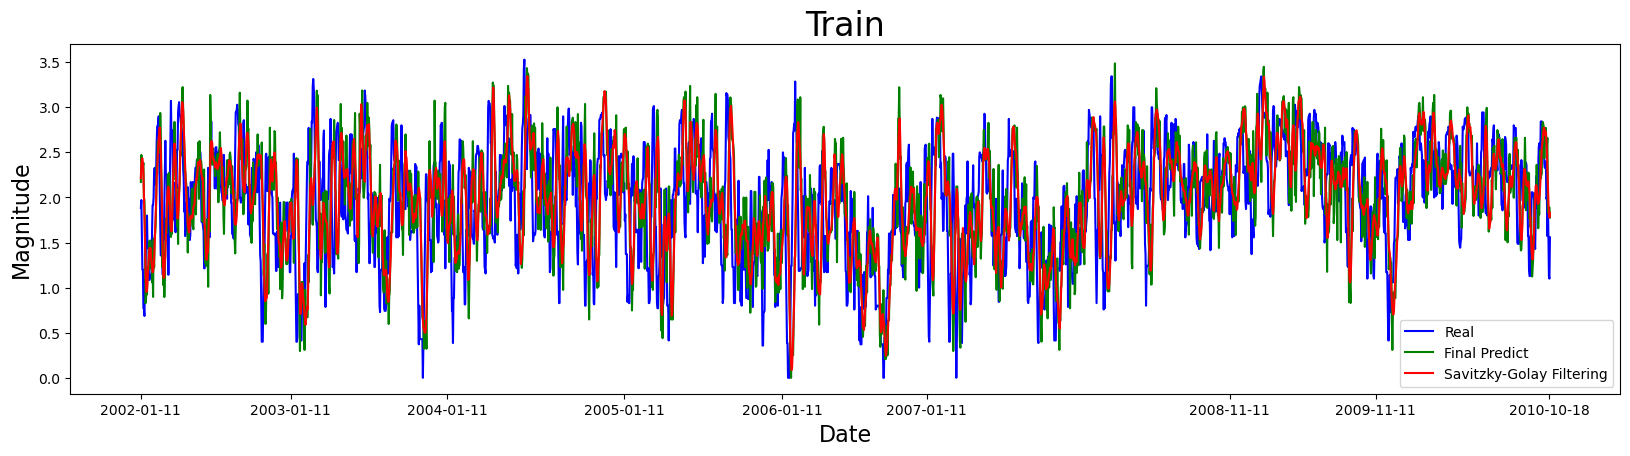

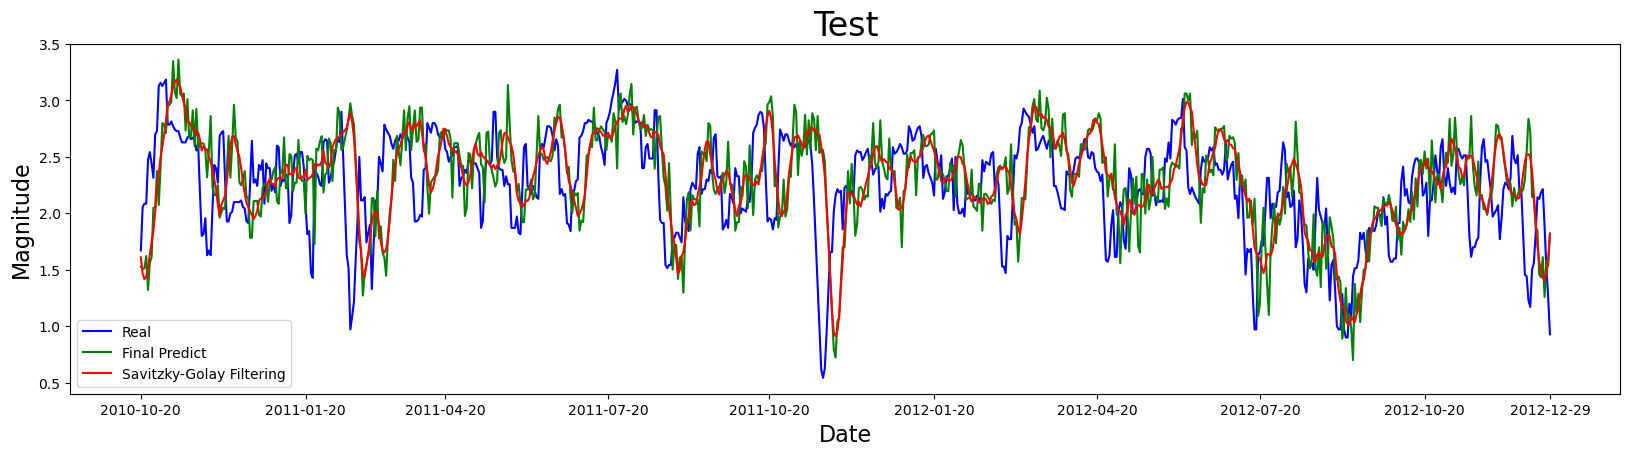

R2	 Train:  -0.12111014648135243 	Test:  -0.05689094264177341
RMSE	 Train:  0.6410885892349842 	Test:  0.44027211509352016


In [343]:
#results for savgol filter
print_plots_and_results(predict_train_final_smoothed_sg, predict_test_final_smoothed_sg, "Savitzky-Golay Filtering")